<h1> QuantumSim - Surface Codes </h1>
Author: Michel Meulen<br>
Date: 05-12-2024<br>
<br>
This chapter introduces quantum error correction (QEC) and delves into the distance three surface code. The content presented here is based on a research paper, which can be found at: ./assets/research/Michel Meulen. To execute this notebook, two libraries are essential: quantumsim, likely familiar to you, and SurfaceCodeQuantumSim, providing circuits for the nine-qubit surface code.

A strong foundation in quantum computing, particularly the concepts explored in the chapter "QuantumSim - Shor's Nine Qubit Code," is recommended. This chapter clarifies the properties of specific quantum gates crucial for understanding the surface code, as well as the two primary error types: phase-flip (Z-errors) and bit-flip (X-errors).



In [1]:
from quantumsim import Circuit, QuantumUtil

Surface Codes - Basics
------------------------
Quantum error correction leverages multiple physical qubits to construct more resilient logical qubits. Within the surface code architecture, qubits are classified into two categories: data qubits, which store the actual quantum information, and ancillary qubits, which facilitate error detection and correction. By measuring ancillary qubits, we can identify potential errors in data qubits and apply appropriate recovery operations to maintain data integrity. This notebook delves into the fundamentals of the surface code, starting with the fundamental building blocks and concluding in a simulation of the distance-3 surface code, providing a comprehensive understanding of the surface code.

Surface Codes - Architecture
----------------------------
Surface codes function through multiple stages. Initially, data qubits are encoded and entangled with each other. A portion of the algorithm is subsequently applied to all data qubits. It is probable that errors, such as bit-flip or phase-flip errors, will be introduced into the data qubits as a result of the application of these gates.

To detect and correct these errors, a syndrome extraction process is employed. During this stage, information about the errors, known as the syndrome, is extracted from the data qubits and stored in ancillary qubits. These ancillary qubits are then measured, and their measurement results are projected onto a classical system.

The classical system processes the measured syndrome values and feeds them into a decoder. The decoder analyzes the syndrome and determines the most likely error pattern that occurred. Based on this analysis, the decoder estimates the necessary recovery action, which involves applying corrective operations to the data qubits to reverse the effects of the errors.

To enhance the noise resilience of the qubits, this cycle of encoding, error detection, and correction can be repeated multiple times within a single quantum computation. However, this increased resilience comes at the cost of longer computation times which is crucial due qubits decoherence times and the speed of the decoder. Below is a visual representation of the different components and steps used to create a surface code system. The double lines indicate classical information flow, in contrast to quantum information flow which is indicated with single lines.

<img src="./assets/images/qec_general/architecture_of_surface_code.drawio.png" alt="Architecture of the surface code" style="width:50%;"/>


Surface Codes - Encoding
--------------------------------
For demonstrating how each stabilizer works all data qubits need to entangled with eachother. To accomplish this we create a four qubit Greenberger-Horne-Zeilinger (GHZ) state.

<img src="./assets/images/surface_code/surface_code_GHZ_circuit.png" alt="Surface code encoding circuit" style="width:60%;"/>


In [2]:
circuit = Circuit(4, 0, True)
d1, d2, d3, d4 = 0, 1, 2, 3

circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d2, d3)
circuit.cnot(d3, d4)

circuit.execute()
circuit.measure(True)


Measured state:
|1111>


'|1111>'

Surface Codes - X Stabilizer
----------------------------

Detects phase flip errors on adjacent data qubits using either CX or CZ in combination with Hadamard gates.

<img src="./assets/images/surface_code/surface_code_x_stabilizer.png" alt="X stabilizer" style="width:60%;"/>

In [3]:
circuit = Circuit(5, 1, True)
d1, d2, d3, d4, a1 = 0, 1, 2, 3, 4

# Encoding
circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d1, d3)
circuit.cnot(d1, d4)

# Introduce Error
circuit.bitflip_error(d1)

# Syndrome extraction
circuit.cnot(d1, a1)
circuit.cnot(d2, a1)
circuit.cnot(d3, a1)
circuit.cnot(d4, a1)

# Measurement of ancillary qubit
circuit.measurement(a1, 0)

circuit.execute()

# If an bit-flip error occured, the register[0] is 1, if there is no error the register[0] is 0
circuit.classicalBitRegister.print()

1


Surface Codes - Z Stabilizer
----------------------------

Detects bit flip errors on adjacent data qubits using either CX or CZ in combination with Hadamard gates.

<img src="./assets/images/surface_code/surface_code_z_stabilizer.png" alt="Z stabilizer" style="width:60%;"/>

In [4]:
circuit = Circuit(5, 1, True)
d1, d2, d3, d4, a1 = 0, 1, 2, 3, 4

# Encoding
circuit.hadamard(d1)
circuit.cnot(d1, d2)
circuit.cnot(d1, d3)
circuit.cnot(d1, d4)

# Introduce Error
circuit.phaseflip_error(d1)

# Syndrome extraction
circuit.hadamard(a1)
circuit.cnot(a1, d1)
circuit.cnot(a1, d2)
circuit.cnot(a1, d3)
circuit.cnot(a1, d4)
circuit.hadamard(a1)

circuit.print_gates_and_descriptions()

# Measurement of ancillary qubit
circuit.measurement(a1, 0)
circuit.execute()

# If an phase-flip error occured, the register[0] is 1, if there is no error the register[0] is 0
# circuit.classicalBitRegister.print()

H....	Hadamard on qubit 0
*X...	CNOT with control qubit 0 and target qubit 1
*.X..	CNOT with control qubit 0 and target qubit 2
*..X.	CNOT with control qubit 0 and target qubit 3
Z....	Phase-flip error (Pauli Z) on qubit 0
....H	Hadamard on qubit 4
X...*	CNOT with control qubit 4 and target qubit 0
.X..*	CNOT with control qubit 4 and target qubit 1
..X.*	CNOT with control qubit 4 and target qubit 2
...X*	CNOT with control qubit 4 and target qubit 3
....H	Hadamard on qubit 4


Surface Codes - The Distance-Three Surface Code
-----------------------------------------------

Smallest surface code architecture capable of detecting and correcting one phase-flip and one bit-flip. It consists of nine data qubits, the lattice size being 3x3, and eight ancillary/ measurement qubits. Circles represent data qubits. Squares represent de ancillary qubits. Each data-ancillary qubit interaction is marked with either colour red, check for bit flips, or blue, check for phase flip. 

<img src="./assets/images/surface_code/rotated_surface_17_code.png" alt="Rotated surface-17 code" style="width:30%;"/>

The code below simulates the rotated surface-17 code with the following steps:
1. Encode all data qubits
2. Introduce errors (bit-flips or phase-flips) (optional)
3. Extract x stabilizer syndrome
4. Extract z stabilizer syndrome
5. Use x stabilizer syndrome to apply recovery method
6. Use z stabilizer syndrome to apply recovery method
7. Decode all data qubits
8. Measure all data qubits and store on classic bit register
9. Plot registers

Phase flip recovery (Pauli Z) applied on qubit: 0
Bit flip recovery (Pauli X) applied on qubit: 0


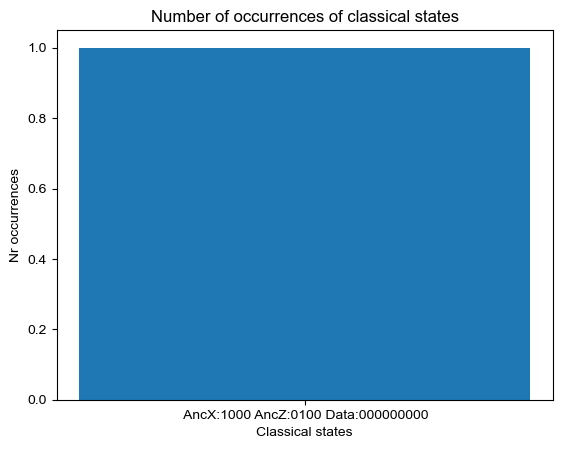

In [5]:
from SurfaceCodeQuantumSim import SurfaceCode
from quantumsim import QuantumUtil

surfaceCode = SurfaceCode()

surfaceCode.add_encoder_circuit()

surfaceCode.add_bit_flip (d1)
surfaceCode.add_phase_flip(d1)

surfaceCode.add_x_stabilizer_syndrome_extraction()
surfaceCode.add_z_stabilizer_syndrome_extraction()
surfaceCode.add_recovery_from_syndrome_x_stabilizer()
surfaceCode.add_recovery_from_syndrome_z_stabilizer()

surfaceCode.add_decoder_circuit()
surfaceCode.add_measure_all_data_qubits()

result = QuantumUtil.measure_circuit_bit_register(surfaceCode.circuit, 1)                    
QuantumUtil.histogram_of_classical_states(result)